## 역전파
모델 파라미터의 최적화는 미분의 성질과 연쇄 법칙을 기반으로 한 역전파를 통해 진행된다. 파이토치는 간단하게 사용할 수 있는 다양한 최적화 방법을 제공하고 있다.

### 그래디언트 텐서
일반적으로 인공 신경망의 최적화라는 것은 손실함수의 최솟값(Global minimum)이 나오게 하는 신경망의 최적 가중차를 찾는 과정이다. 따라서 최적화를 위해 변화량을 타나내는 미분은 필수적인 요소다. 이때 깊은 인공 신경망의 구조는 입력값의 들어와 다중의 층을 지나 출력값을 산술하는 합숭 함수 형태임을 알 수 있다. 따라서 미분의 성질과 연쇄 법칙을 통해 원하는 변수에 대한 미분값을 계산할 수 있다. 다만 층이 깊어지거나 구조가 복잡할 수록 계산이 복잡해지기 때문에 파이토치는 자동미분계산함수를 제공한다.

In [4]:
import torch
x = torch.ones(2,2,requires_grad = True)
y = x+1
z = x*y**2
r = z.mean()
print("Result: ", r)

Result:  tensor(4., grad_fn=<MeanBackward0>)


requires_grad = True는 해당 텐서를 기준으로 모든 연산들을 추적하여 그레디언트라고 하는 미분값의 모임을 계산할 수 있게 한다. 즉 x에 대해서 연쇄 법칙을 이용한 미분이 가능하다는 것이다. 다음 예시를 보면 y는 x에 대한식, z는 y에 대한 식 r은 z에 대한 식이다. 따라서 이는 합성 함수의 개념으로써 최종 함수 r은 x에 대해서 표현 및 미분이 가능하다.  
미분을 한다는 것은 미분이 가능한 함수라는 것이고 함수라는 것은 미분하려는 변수가 함수의 조건을 만족해야 한다. 함수의 조건은 정의역에 속하는 주어진 값 x는 오직 하나에 대한 r값이 치역에 존재해야 한다. 따라서 y와 z는 함수의 조건에 만족하지 않고 일련의 계산 과정이기 때문에 y와 x에 대해서 미분을 하려고 했을 때 에러가 난다. 따라서 모델의 최적화를 위해 단일 값이 나오는 손실 함수를 정의한다.

In [5]:
r.backward()
print(x.grad)

tensor([[2., 2.],
        [2., 2.]])


r를 기준으로 역전파를 진행하겠다는 의미 이므로 $dr\over dx$을 계산한다. 따라서 $r=$$ z_1+z_2+z_3+z_4 \over 4$ 이고 $z_i = 2y_i^2 = 2(x_i+1)^2$ 이므로 $dr\over dx$$=x_i+1$이다 모든 x의 성분이 1이므로 그래디언트 x.grad를 통해 나온 미분값은 모두 2가 된다.

### 자동 미분 - 선형회귀식
자동 미분을 위해 과거에는 Tensor을 덮어씌워 사용하는 Variable를 사용했다. 하지만 현재 텐서는 자동 미분을 위한 기능을 직접 제공하기 때문에 Tensro를 바로 시용하자

In [6]:
import torch
from matplotlib import pyplot as plt
x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x + torch.rand(5,1)
num_features = x.shape[1]

torch.FloatTensor(range(5)는 리스트 range(5)를 이용해 텐서로 만든다. 이대 원래 크기는 1차원인 torch.Size(5)이라서 행렬 계산을 위해 2차원 배열로 만들어 준다. 이때 unsqueeze(1)은 1번째 위치의 차원을 늘려주는 역할을 하여 최종적으로 x의 크기는 torch.Size(5,1)이 된다. 만약 unsqueeze(0) 크기는 torch.Size(1,5)가 된다.  
변수의 개수를 저장하는 num_features를 만든다. x의 크기는 torch.Size([5,1])이므로 인스턴스의 개수가 5개이고 변수의 개수가 1개인 데이터다. 따라서 x.shape[1]은 변수의 개수가 된다.

In [7]:
w = torch.randn(num_features, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

선형식은 y = xw+b로 표현된다. 따라서 w는 5x1 데이터와 곱할 수 있어야 하며 예측값이 하나로 나와야 하므로 1(피처수) x 1(출력값의 크기)인 배열로 정의하자 따라서 xw는 5x1이 된다. 편향 b는 모든 인스턴스에 동일한 숫자르 ㄹ더해주는 것으로 크기가 1인 텐서로 정의한다. 우리의 목표는 xw+b가 잘 예측을 할 수 있는 w와 b를 찾는 것이다. 초깃값에 대한 좋은 정보가 있을 경우에는 좋은 값으로 초깃값을 설정한다면 수렴이 빠르고 저오학도도 높아질 수 있지만 모르는 경우에는 초기값을 무작위로 준다. 여기서는 torch.nandn을 사용한다.  

가중치를 업데이트하는 방법은 매우 다양하다. 가장 널리 사용되는 방법은 경사 하강법(Gradient descent)은 목적 함수인 손실 함수를 기준으로 그래디언트를 계산하여 변수를 최적화하는 기법이다.

In [8]:
learning_rate = 1e-3
optimizer = torch.optim.SGD([w,b], lr=learning_rate)

torch.optim.SGD내부에 변수를 리스트로 묶어 넣어주고 적절한 학습률을 정하여 자동으로 가중치와 편향을 업데이트 한다.

In [9]:
loss_stack = []
for epoch in range(1001):
    optimizer.zero_grad()
    y_hat = torch.matmul(x,w)+b
    loss = torch.mean((y_hat-y)**2)
    loss.backward()
    optimizer.step()
    loss_stack.append(loss.item())
    
    if epoch %100 ==0:
        print(f'Epoch{epoch}:{loss.item()}')

Epoch0:38.781959533691406
Epoch100:2.861367702484131
Epoch200:0.4221342206001282
Epoch300:0.2383372038602829
Epoch400:0.2085200995206833
Epoch500:0.1910281926393509
Epoch600:0.17610886693000793
Epoch700:0.1629093736410141
Epoch800:0.15119849145412445
Epoch900:0.1408059298992157
Epoch1000:0.1315830945968628


In [10]:
with torch.no_grad():
    y_hat = torch.matmul(x,w)+b

최종 학습된 w, b로 예측값을 산출한다. 이때 최적화를 사용하지 않으므로 requires_grad를 비활성화한다. 이떼 with torch.no_grad():를 이용하여 구문 내부에 있는 requires_grad가 작동하지 않도록 할 수 있다.

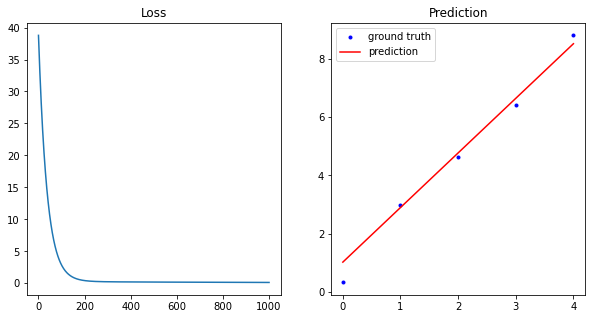

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x, y,'.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth','prediction'])
plt.title("Prediction")
plt.show()